In [ ]:
#all imports here

from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%run loading_data.ipynb
#use sub_data to get data from the subject

In [3]:
sub_data

[array([[ -39.005 , -107.9   ,  -50.716 , ...,  -92.558 ,  -37.966 ,
          -49.517 ],
        [-115.81  ,  -48.779 ,  -54.964 , ...,   49.244 ,  -55.551 ,
         -148.53  ],
        [-135.81  ,  -65.256 ,  -19.337 , ...,    9.0708, -204.49  ,
           14.702 ],
        ...,
        [ -16.092 ,   39.493 ,   46.735 , ...,   19.671 ,    3.3545,
         -119.9   ],
        [ -23.409 ,   23.32  ,   42.812 , ...,  -30.822 ,  -53.967 ,
           97.689 ],
        [ -63.04  ,   12.525 ,   50.778 , ...,   48.854 ,  157.55  ,
          -20.452 ]]),
 array([[   2.6365 ,   24.647  ,  -38.828  , ...,    2.9023 ,  -50.067  ,
          177.48   ],
        [  12.409  ,   55.107  ,  -46.051  , ...,   53.574  ,  116.53   ,
         -124.21   ],
        [ -16.205  ,   18.65   ,  -59.675  , ...,  -26.072  ,  117.12   ,
           88.34   ],
        ...,
        [   1.853  ,  -53.554  ,   39.991  , ...,   90.494  ,  -92.436  ,
           16.657  ],
        [   1.771  ,  -53.682  ,   64.128  , ...

In [5]:
#distance function
atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 

atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)

def distance_between_coords(id1, id2):
    return np.sqrt(np.sum([(atlas_coords[id2][i] - atlas_coords[id1][i])**2 for i in range(3)]))

In [ ]:
#-1 is the left hemisphere, 1 is the right hemisphere, 0 is the middle
node_values = list(map(lambda x: 1 if x[0] > 0 else -1 if x[0] < 0 else 0, atlas_coords))

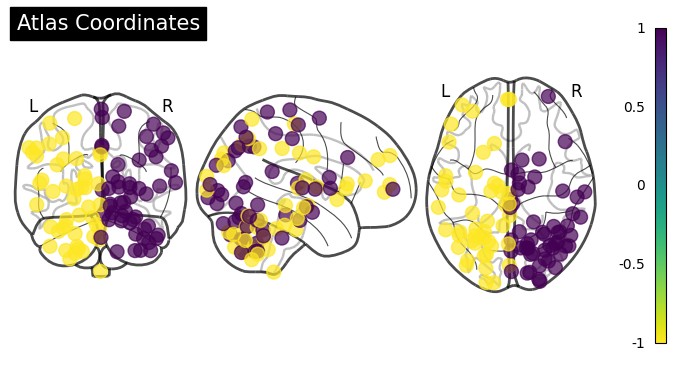

In [14]:
# Plot the coordinates on the brain
plotting.plot_markers(node_values=node_values, node_coords=atlas_coords, title="Atlas Coordinates")

# Show the plot
plotting.show()

In [18]:
%run sliding_windows.ipynb

In [19]:
sliding_windows?

Signature: sliding_windows(data, num_windows, create_figure=False)
Docstring:
data: is the data that we want to be split into whindows, one subject data
num_windows: is the number of windows we want to split the data into
create_figure: if True, it will create a figure with the windows, if False, it will not create a figure
File:      /var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_14034/1673354.py
Type:      function

In [119]:
windows12 = sliding_windows(sub_data[1], 12)

In [21]:
distances = []
df = pd.DataFrame({'x':[], 'y': [], 'cor':[], 'dist':[]})
for mat in windows12:
    top_correlations = percentile(mat, 99.9)
    top_correlations_id = top_correlations.keys()
    indices = np.triu_indices(100, 1)
    for x,y in zip(*indices):
        distance = distance_between_coords(x, y)
        distances.append(distance)
        df.loc[len(df)] = [x, y, mat[x][y], distance]
df.shape     

(59400, 4)

In [22]:
df.head()

,x,y,cor,dist
0,0.0,1.0,0.032143,63.656530
1,0.0,2.0,0.386550,17.697323
2,0.0,3.0,-0.037099,47.891793
3,0.0,4.0,-0.109977,114.471995
4,0.0,5.0,-0.196184,49.125059


In [29]:
#adding columns for x and y hemisphere
df['x_hemisphere'] = df['x'].apply(lambda x: 1 if atlas_coords[int(x)][0] > 0 else -1 if atlas_coords[int(x)][0] < 0 else 0)
df['y_hemisphere'] = df['y'].apply(lambda x: 1 if atlas_coords[int(x)][0] > 0 else -1 if atlas_coords[int(x)][0] < 0 else 0)
#same or different hemisphere
df['same_hemisphere'] = df['x_hemisphere'] == df['y_hemisphere']


In [ ]:
atlas_labels = [label.replace("Right_", "").replace("Left_", "") for label in brain_region]
def same_brain_region(index1, index2, atlas_labels):
    return atlas_labels[index1] == atlas_labels[index2]

df['same_brain_region'] = df.apply(lambda x: same_brain_region(int(x['x']), int(x['y']), atlas_labels), axis=1)

In [95]:
df

,x,y,cor,dist,x_hemisphere,y_hemisphere,same_hemisphere,same_brain_region
0,0.0,1.0,0.032143,63.656530,1,1,True,False
1,0.0,2.0,0.386550,17.697323,1,1,True,False
2,0.0,3.0,-0.037099,47.891793,1,-1,False,False
3,0.0,4.0,-0.109977,114.471995,1,-1,False,False
4,0.0,5.0,-0.196184,49.125059,1,1,True,False
...,...,...,...,...,...,...,...,...
59395,96.0,98.0,0.014190,18.029568,1,1,True,False
59396,96.0,99.0,-0.022173,30.792223,1,-1,False,False
59397,97.0,98.0,-0.002498,19.726379,-1,1,False,False
59398,97.0,99.0,-0.010765,18.260050,-1,-1,True,False


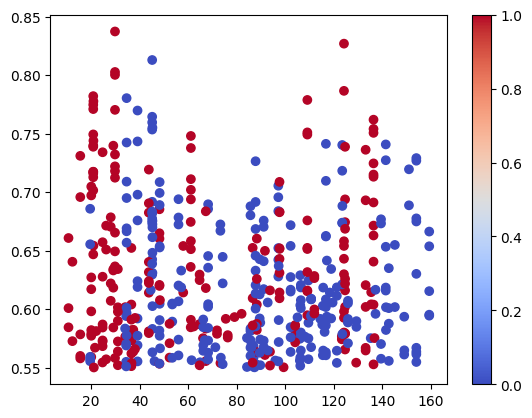

In [109]:
from matplotlib.colors import ListedColormap

sample = df[df['cor'] > 0.55]
# cmap = ListedColormap(['#ffcc00', '#4b0082'])  # Blue and Orange
plt.scatter(x=sample['dist'], y=sample['cor'], c=sample['same_hemisphere'], cmap='coolwarm')
plt.colorbar()

In [99]:
print('Proportion in the same hemisphere:',np.mean(sample['same_hemisphere']))
print('Proportion in the same brain region:',np.mean(sample['same_brain_region']))

Proportion in the same hemisphere: 0.46322067594433397
Proportion in the same brain region: 0.10536779324055666


In [45]:
from atlasreader.atlasreader import read_atlas_peak
brain_region = []
print("BRAIN REGIONS:\n--------------")
for atlas_coord in atlas_coords:
    region = read_atlas_peak("neuromorphometrics", atlas_coord)
    print(region)
    brain_region += [region]

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

BRAIN REGIONS:
--------------
Right_OCP_occipital_pole
Right_AnG_angular_gyrus
Right_IOG_inferior_occipital_gyrus
Left_Cun_cuneus
Left_SMG_supramarginal_gyrus
Right_MOG_middle_occipital_gyrus
Right_SMG_supramarginal_gyrus
Right_MOG_middle_occipital_gyrus
Left_AnG_angular_gyrus
Right_PCu_precuneus
Right_LiG_lingual_gyrus
Left_SMG_supramarginal_gyrus
Left_SOG_superior_occipital_gyrus
Left_AnG_angular_gyrus
Left_PCu_precuneus
Right_SOG_superior_occipital_gyrus
Right_Calc_calcarine_cortex
Right_SPL_superior_parietal_lobule
no_label
Left_MOG_middle_occipital_gyrus
Left_PoG_postcentral_gyrus
no_label
Right_SMG_sup

In [46]:
far_connections = df[(df['cor'] > 0.65) & (df['dist'] > 80)]
far_connections

,x,y,cor,dist,x_hemisphere,y_hemisphere,same_hemisphere
402,4.0,17.0,0.687881,85.642902,-1,1,False
790,8.0,35.0,0.713103,136.363713,-1,-1,True
798,8.0,43.0,0.675764,109.086208,-1,-1,True
880,9.0,35.0,0.718237,123.463927,1,-1,False
1071,11.0,49.0,0.695599,97.120689,-1,1,False
...,...,...,...,...,...,...,...
50734,13.0,39.0,0.662038,116.735387,-1,1,False
51539,23.0,39.0,0.660236,88.259562,1,1,True
55677,13.0,32.0,0.826905,124.185952,-1,-1,True
55684,13.0,39.0,0.741255,116.735387,-1,1,False


In [124]:
array = windows12[0].copy()
array[array < 0.55] = 0

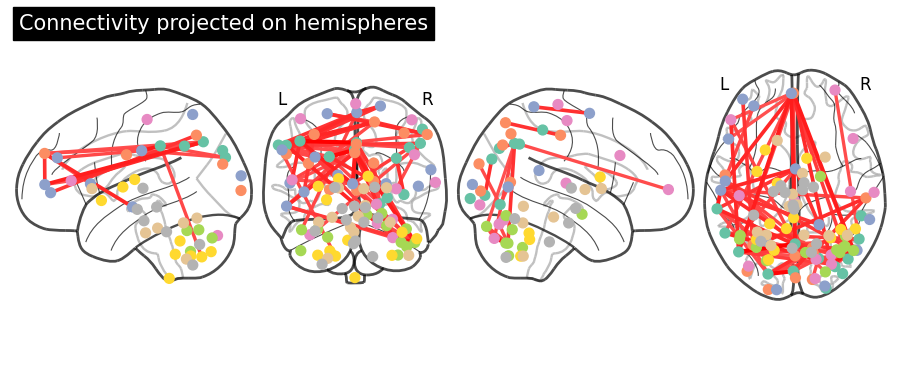

In [125]:
plotting.plot_connectome(
    array,
    atlas_coords,
    title="Connectivity projected on hemispheres",
    display_mode="lyrz",
)

In [126]:
view = plotting.view_connectome(array, atlas_coords)
view

In [86]:
atlas_labels = [label.replace("Right_", "").replace("Left_", "") for label in brain_region]
def same_brain_region(index1, index2, atlas_labels):
    return atlas_labels[index1] == atlas_labels[index2]

df['same_brain_region'] = df.apply(lambda x: same_brain_region(int(x['x']), int(x['y']), atlas_labels), axis=1)

In [87]:
df

,x,y,cor,dist,x_hemisphere,y_hemisphere,same_hemisphere,same_brain_region
0,0.0,1.0,0.032143,63.656530,1,1,True,False
1,0.0,2.0,0.386550,17.697323,1,1,True,False
2,0.0,3.0,-0.037099,47.891793,1,-1,False,False
3,0.0,4.0,-0.109977,114.471995,1,-1,False,False
4,0.0,5.0,-0.196184,49.125059,1,1,True,False
...,...,...,...,...,...,...,...,...
59395,96.0,98.0,0.014190,18.029568,1,1,True,False
59396,96.0,99.0,-0.022173,30.792223,1,-1,False,False
59397,97.0,98.0,-0.002498,19.726379,-1,1,False,False
59398,97.0,99.0,-0.010765,18.260050,-1,-1,True,False


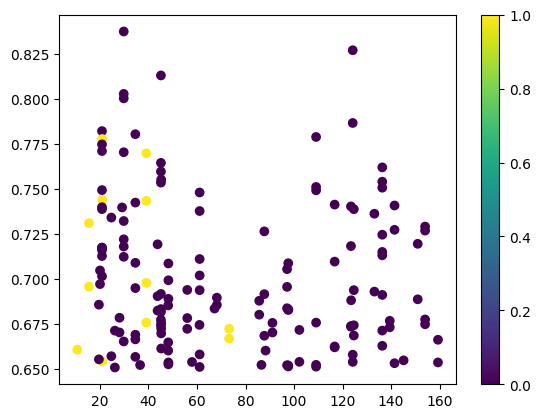

In [88]:
sample = df[df['cor'] > 0.65]
plt.scatter(x=sample['dist'], y=sample['cor'], c=sample['same_brain_region'])
plt.colorbar()